# Crawl HTML

In [1]:
from calendar import monthrange
import datetime as dt
import time
import csv
import os
from bs4 import BeautifulSoup as bs
import progressbar as pb

from concurrent.futures import ThreadPoolExecutor as Executor

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

* Sử dụng selenium để crawl

In [2]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('log-level=3')
# Cài chrome driver nếu chưa có
wd = webdriver.Chrome(ChromeDriverManager().install(), options=options)
wd.close()
wd.quit()

[WDM] - Current google-chrome version is 87.0.4280
[WDM] - Get LATEST driver version for 87.0.4280
[WDM] - Driver [C:\Users\pumpk\.wdm\drivers\chromedriver\win32\87.0.4280.88\chromedriver.exe] found in cache


* Crawl từ trang https://www.wunderground.com
* Dữ liệu được lấy trong 10 năm từ 2010 đến 2020
* Dữ liệu được lấy từ trạm thời tiết của sân bay Tân Sơn Nhất(VVTS)

In [3]:
# Đường dẫn của chrome driver(được in ra ở phía trên)
chrome_path = 'C:/Users/pumpk/.wdm/drivers/chromedriver/win32/87.0.4280.88/chromedriver.exe'

data_path = 'data_html'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

data_html_path = f'{data_path}/html'
if not os.path.isdir(data_html_path):
    os.mkdir(data_html_path)
    
location = 'VVTS'
timeout = 15

years = list(range(2010, 2020, 1))

In [4]:
def get_html(year):
    wd = webdriver.Chrome(executable_path=chrome_path, options=options)
    
    wd.get('https://www.wunderground.com')
    
    # Đổi sang metric
    elements = wd.find_elements_by_class_name('close-setting')
    while len(elements) == 0:
        elements = wd.find_elements_by_class_name('close-setting')
    elements[0].click()
    wd.find_element_by_xpath("//a[contains(text(),'°C')]").click()
    
    cur = dt.datetime(year, 1, 1)
    end = dt.datetime(year + 1, 1, 1)
    
    # Lấy từng ngày
    while cur != end:
        try:
            start = time.time()
            date = cur.strftime("%Y-%m-%d")
            
            # Kiểm tra ngày này đã được lấy chưa
            if date not in exist_dates:
                url = f'https://www.wunderground.com/history/daily/{location}/date/{date}'

                wd.get(url)

                # Chờ trang web load phần dữ liệu cần lấy
                elements = wd.find_elements_by_class_name('mat-table')
                while len(elements) == 0:
                    time.sleep(0.2)
                    elements = wd.find_elements_by_class_name('mat-table')
                    
                    # Nếu không có thì chuyển sang ngày tiếp
                    if time.time() - start > timeout:
                        print(f'{date}: no data')
                        break
                
                # Nếu có dữ liệu thì lưu tag của html chưa dữ liệu xuống để kiểm tra và xử lý lại sau.
                if len(elements) != 0:
                    table = elements[0]
                    table = table.find_element_by_tag_name('tbody')

                    html = table.get_attribute('innerHTML')
                    with open(f'{data_html_path}/{date}', 'w+', encoding='utf-8') as f:
                        f.write(html)
                
        except Exception as ex:
            print(f'{date}: {str(ex)}')
            print(f'{date}: {ex}')
        
        cur += dt.timedelta(days=1)
        
    wd.close()
    wd.quit()

* Sử dụng multi-thread, chạy nhiều browser 1 lần để crawl nhanh hơn

In [5]:
start = time.time()

# Chạy song song nhiều browser, max_workers tương ứng với số lượng browser, mỗi browser ứng với 1 năm.
with Executor(max_workers=10) as exe:
    exe.map(get_html, years)
    
print(f'Total: {len(os.listdir(data_html_path))}')
print(f'Elapsed Time: {time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))}')

2016-06-19: no data
2017-09-21: no data
2017-09-22: no data
2017-09-23: no data
2017-09-24: no data
2013-10-02: no data
2013-10-03: no data
2013-10-04: no data
2013-10-05: no data
2013-10-06: no data
2016-10-15: no data
2015-10-31: no data
2015-11-01: no data
2015-11-02: no data
Total: 3640
Elapsed Time: 00h 54m 54s


* Chạy lại lần nữa để lấy những ngày bị thiếu(1 số ngày vẫn không lấy được do không tồn tại dữ liệu)  
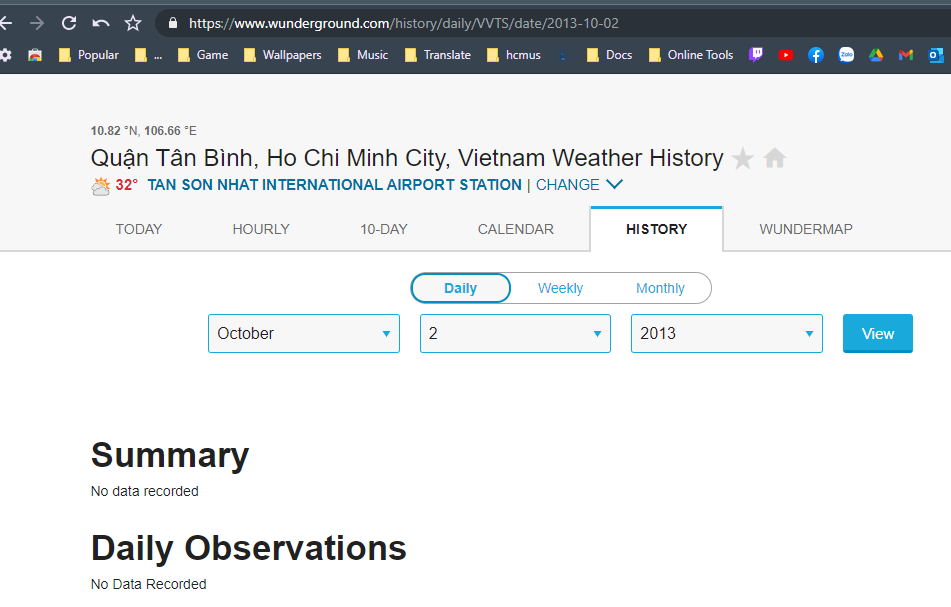

In [8]:
start = time.time()
# Lấy những ngày đã crawl
exist_dates = set(os.listdir(data_html_path))

# Chạy song song nhiều browser, max_workers tương ứng với số lượng browser, mỗi browser ứng với 1 năm.
with Executor(max_workers=10) as exe:
    exe.map(get_html, years)
    
print(f'Total: {len(os.listdir(data_html_path))}')
print(f'Elapsed Time: {time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))}')

2013-10-02: no data
2015-10-31: no data
2013-10-03: no data
2015-11-01: no data
2013-10-04: no data
2015-11-02: no data
2013-10-05: no data
2013-10-06: no data
Total: 3644
Elapsed Time: 00h 01m 31s


In [9]:
def save(path, data):
    with open(path, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = list(data[0].keys())
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        writer.writerows(data)
    

# Tính ngày cuối cùng trong tháng
def end_day(date):
    return monthrange(month=date.month, year=date.year)[1]

        
# Parse dữ liệu từ file đã crawl được trước đó
def get_data(file):
    data = []
    
    with open(f'{data_html_path}/{file}', encoding='utf-8') as f:
        html = f.read()
        try:
            table = bs(html, 'html.parser').find_all('tr', {'class': 'mat-row'})

            for row in table:
                data.append({
                    'date': file + ' '\
                            + row.find('td', {'class': 'mat-column-dateString'})\
                            .find('span', {'ng-star-inserted'}).text,
                    'temp': int(row.find('td', {'class': 'mat-column-temperature'})\
                            .find('span', {'wu-value'}).text),
                    'dewPt': int(row.find('td', {'class': 'mat-column-dewPoint'})\
                            .find('span', {'wu-value'}).text),
                    'rh': int(row.find('td', {'class': 'mat-column-humidity'})\
                            .find('span', {'wu-value'}).text),
                    'wdir_cardinal': row.find('td', {'class': 'mat-column-windcardinal'})\
                            .find('span', {'ng-star-inserted'}).text,
                    'wspd': int(row.find('td', {'class': 'mat-column-windSpeed'})\
                            .find('span', {'wu-value'}).text\
                            .replace(',', '')),
                    'pressure': float(row.find('td', {'class': 'mat-column-pressure'})\
                            .find('span', {'wu-value'}).text\
                            .replace(',', '')),
                    'wx_phrase': row.find('td', {'class': 'mat-column-condition'})\
                            .find('span', {'ng-star-inserted'}).text
                })
        except Exception as ex:
            print(f'{file}: {str(ex)}')
            print(f'{file}: {ex}')
    
    return data

In [10]:
files = os.listdir(data_html_path)
n = len(files)

data = []
for i in pb.progressbar(range(n)):
    data.extend(get_data(files[i]))

print(f'Total: {len(data)}')
save(f'data_html/data.csv', data)

100% (3644 of 3644) |####################| Elapsed Time: 0:22:03 Time:  0:22:03


Total: 171762
